# Overview
This is a simple end to end example of how you can use SAS Viya for analysis
The example follows these steps:
1. Importing the needed Python packages
1. Starting a CAS session on an already running CAS server
1. Checking the server status
1. Loading data from the local file system to the CAS server
1. Explore the data
1. Impute missing values
1. Partition the data into training and validation partitions
1. Build a decision tree
1. Build a neural network
1. Build a decision forest
1. Build a gradient boost
1. Assess the models
1. Build ROC charts

## Setup and initialize

Find doc for all the CAS actions [here](http://casjml01.unx.sas.com:8080/job/Actions_ref_doc_vb005/ws/casaref/index.html) 

In this code we import the needed packages and we assign variables for the modeling details that will be used later in the analysis

In [1]:
from swat import *
from swat.render import render_html
from pprint import pprint
from matplotlib import pyplot as plt
import pandas as pd
import sys
%matplotlib inline

target          = "bad"
class_inputs    = ["reason", "job"]
class_vars      = [target] + class_inputs
interval_inputs = ["im_clage", "clno", "im_debtinc", "loan", "mortdue", "value", "im_yoj", "im_ninq", "derog", "im_delinq"]
all_inputs      = interval_inputs + class_inputs

indata_dir = '/home/sasdemo/WTW_Demo_Repo/data'
indata = 'hmeq'

## Start CAS session

In this code we assign values for the cashost, casport, and casauth values. These are then used to establish a CAS session named `sess`.

In [2]:
cashost='localhost'
casport=5570
casauth='~/.authinfo'
sess = CAS(cashost, casport, authinfo=casauth, caslib="casuser")

# Load the needed action sets for this example:
sess.loadactionset(actionset="dataStep")
sess.loadactionset(actionset="dataPreprocess")
sess.loadactionset(actionset="cardinality")
sess.loadactionset(actionset="sampling")
sess.loadactionset(actionset="regression")
sess.loadactionset(actionset="decisionTree")
sess.loadactionset(actionset="neuralNet")
sess.loadactionset(actionset="svm")
sess.loadactionset(actionset="astore")
sess.loadactionset(actionset="percentile")

NOTE: Added action set 'dataStep'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'regression'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'neuralNet'.
NOTE: Added action set 'svm'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.000608s, user: 0.00055s, mem: 0.221mb

## Load data into CAS



In [22]:
if not sess.table.tableExists(table=indata).exists:
    indata = sess.upload_file(indata_dir+"/"+indata+".csv", casout={"name":indata})

NOTE: Cloud Analytic Services made the uploaded file available as table HMEQ in caslib CASUSER(sasdemo).
NOTE: The table HMEQ has been created in caslib CASUSER(sasdemo) from binary data uploaded to Cloud Analytic Services.


## Explore and Impute missing values

In [23]:
sess.summary(indata)

,Column,Min,Max,N,NMiss,Mean,Sum,Std,StdErr,Var,USS,CSS,CV,TValue,ProbT,Skewness,Kurtosis
0,BAD,0.000000,1.000000,5960.0,0.0,0.199497,1.189000e+03,0.399656,0.005177,1.597245e-01,1.189000e+03,9.517985e+02,200.331950,38.536557,2.720203e-290,1.504317,0.263057
1,LOAN,1100.000000,89900.000000,5960.0,0.0,18607.969799,1.109035e+08,11207.480417,145.172668,1.256076e+08,2.812185e+12,7.484958e+11,60.229464,128.178190,0.000000e+00,2.023781,6.932590
2,MORTDUE,2063.000000,399550.000000,5442.0,518.0,73760.817200,4.014064e+08,44457.609458,602.652327,1.976479e+09,4.036208e+13,1.075402e+13,60.272664,122.393649,0.000000e+00,1.814481,6.481866
3,VALUE,8000.000000,855909.000000,5848.0,112.0,101776.048741,5.951863e+08,57385.775334,750.413385,3.293127e+09,7.983063e+13,1.925491e+13,56.384362,135.626644,0.000000e+00,3.053344,24.362805
4,YOJ,0.000000,41.000000,5445.0,515.0,8.922268,4.858175e+04,7.573982,0.102642,5.736521e+01,7.457556e+05,3.122962e+05,84.888530,86.926047,0.000000e+00,0.988460,0.372072
5,DEROG,0.000000,10.000000,5252.0,708.0,0.254570,1.337000e+03,0.846047,0.011674,7.157951e-01,4.099000e+03,3.758640e+03,332.343880,21.805933,5.478603e-101,5.320870,36.872763
6,DELINQ,0.000000,15.000000,5380.0,580.0,0.449442,2.418000e+03,1.127266,0.015369,1.270728e+00,7.922000e+03,6.835248e+03,250.814336,29.244135,1.326786e-174,4.023150,23.565449
7,CLAGE,0.000000,1168.233561,5652.0,308.0,179.766275,1.016039e+06,85.810092,1.141398,7.363372e+03,2.242600e+08,4.161041e+07,47.734255,157.496508,0.000000e+00,1.343412,7.599549
8,NINQ,0.000000,17.000000,5450.0,510.0,1.186055,6.464000e+03,1.728675,0.023416,2.988317e+00,2.395000e+04,1.628334e+04,145.749978,50.651202,0.000000e+00,2.621984,9.786507
9,CLNO,0.000000,71.000000,5738.0,222.0,21.296096,1.221970e+05,10.138933,0.133848,1.027980e+02,3.192071e+06,5.897519e+05,47.609351,159.106532,0.000000e+00,0.775052,1.157673


#### Explore data and plot missing values

NOTE: Writing cardinality.
NOTE: status = 0.
NOTE: The Cloud Analytic Services server processed the request in 0.013101 seconds.
----------------------------------Data Summary----------------------------------


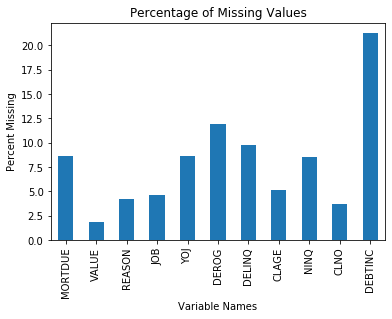

In [24]:
sess.cardinality.summarize(
  table=indata, 
  cardinality={"name":"data_card", "replace":True}
)

tbl_data_card=sess.CASTable('data_card')
tbl_data_card.where='_NMISS_>0'
print("Data Summary".center(80, '-')) # print title
tbl_data_card.fetch() # print obs

tbl_data_card.vars=['_VARNAME_', '_NMISS_', '_NOBS_']
allRows=20000  # Assuming max rows in data_card table is <= 20,000
df_data_card=tbl_data_card.fetch(to=allRows)['Fetch']
df_data_card['PERCENT_MISSING']=(df_data_card['_NMISS_']/df_data_card['_NOBS_'])*100

tbl_forplot=pd.Series(list(df_data_card['PERCENT_MISSING']), index=list(df_data_card['_VARNAME_']))
ax=tbl_forplot.plot(
  kind='bar', 
  title='Percentage of Missing Values'
)
ax.set_ylabel('Percent Missing')
ax.set_xlabel('Variable Names');

#### Impute missing values

In [25]:
r=sess.dataPreprocess.transform(
  table=indata,
  casOut={"name":"hmeq_prepped", "replace":True},
  copyAllVars=True,
  outVarsNameGlobalPrefix="IM",
  requestPackages=[
    {"impute":{"method":"MEAN"}, "inputs":{"clage"}},
    {"impute":{"method":"MEDIAN"}, "inputs":{"delinq"}},
    {"impute":{"method":"VALUE", "valuesInterval":{2}}, "inputs":{"ninq"}},
    {"impute":{"method":"VALUE", "valuesInterval":{35.0, 7, 2}}, "inputs":{"debtinc", "yoj"}}
  ]
)
render_html(r)

Transformation Requests for HMEQ 
 Actual Name for Transformation 
 Number of Transformation Variables 
 Imputation Method 
 
 
 _TR1 1 Mean 
 _TR2 1 Median 
 _TR3 1 Value 
 _TR4 2 Value 
 
 
 
 
 Variable Transformation Information for HMEQ 
 Variable 
 Transformation Name 
 Result Variable 
 Number of Observations 
 Number of Missing 
 Imputed Value 
 
 
 CLAGE IM IM_CLAGE 5652 308 179.77 
 DEBTINC IM IM_DEBTINC 4693 1267 2.0000 
 DELINQ IM IM_DELINQ 5380 580 0 
 NINQ IM IM_NINQ 5450 510 2.0000 
 YOJ IM IM_YOJ 5445 515 35.0000 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(sasdemo) hmeq_prepped 5960 18 CASTable('hmeq_prepped', caslib='CASUSER(sasdemo)')

## Partition data into Training and Validation

The stratified action in the sampling actionset allows us to create two partition and observe the reponse rate of the target variable `bad` in both training and validation

In [26]:
sess.sampling.stratified(
  table={"name":"hmeq_prepped", "groupBy":target},
  output={"casOut":{"name":"hmeq_part", "replace":True}, "copyVars":"ALL"},
  samppct=70,
  partind=True
)

NOTE: Stratified sampling is in effect.
NOTE: Using SEED=1228335899 for sampling.


[STRAFreq]

 Frequencies
 
    ByGrpID           BAD  NObs  NSamp
 0        0             0  4771   3340
 1        1             1  1189    832

[OutputCasTables]

              casLib       Name Label  Rows  Columns  \
 0  CASUSER(sasdemo)  hmeq_part        5960       19   
 
                                            casTable  
 0  CASTable('hmeq_part', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.019s, user: 0.0164s, sys: 0.0102s, mem: 31.8mb

## Decision Tree

In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `tree_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `tree_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [27]:
sess.decisionTree.dtreeTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  target="bad",
  nominals=class_vars,
  crit="GAIN",
  prune=True,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"tree_model", "replace":True}
)

# Score 
sess.decisionTree.dtreeScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"tree_model"},
  casOut={"name":"_scored_tree", "replace":True},
  copyVars={"bad", "_partind_"}
)

# Create p_bad0 and p_bad1 as _dt_predp_ is the probability of event in _dt_predname_
sess.dataStep.runCode(code = """
data _scored_tree; 
    length p_bad1 p_bad0 8.;
    set _scored_tree; 
    if _dt_predname_=1 then do; 
        p_bad1=_dt_predp_; 
        p_bad0=1-p_bad1; 
    end; 
    if _dt_predname_=0 then do; 
        p_bad0=_dt_predp_; 
        p_bad1=1-p_bad0; 
    end; 
run;
"""
)


NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:79    0:176
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 12 times)
      0:79    0:176  (occurred 12 times)


[InputCasTables]

              casLib          Name  Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_tree  5960       14   
 
                                             casTable  
 0  CASTable('_scored_tree', caslib='CASUSER(sasde...  

[OutputCasTables]

              casLib          Name  Rows  Columns  Append Promoted  \
 0  CASUSER(sasdemo)  _scored_tree  5960       16     NaN        N   
 
                                             casTable  
 0  CASTable('_scored_tree', caslib='CASUSER(sasde...  

+ Elapsed: 0.0184s, user: 0.0184s, sys: 0.0214s, mem: 8.17mb

## Decision Forest

In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `forest_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `forest_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [28]:
sess.decisionTree.forestTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  nTree=50,
  nBins=20,
  leafSize=5,
  maxLevel=21,
  crit="GAINRATIO",
  varImp=True,
  missing="USEINSEARCH",
  vote="PROB",
  casOut={"name":"forest_model", "replace":True}
)

# Score 
sess.decisionTree.forestScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"forest_model"},
  casOut={"name":"_scored_rf", "replace":True},
  copyVars={"bad", "_partind_"},
  vote="PROB"
)

# Create p_bad0 and p_bad1 as _rf_predp_ is the probability of event in _rf_predname_
sess.dataStep.runCode(
  code="data _scored_rf; set _scored_rf; if _rf_predname_=1 then do; p_bad1=_rf_predp_; p_bad0=1-p_bad1; end; if _rf_predname_=0 then do; p_bad0=_rf_predp_; p_bad1=1-p_bad0; end; run;"
)

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:104
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 12 times)
      0:35    0:104  (occurred 12 times)


[InputCasTables]

              casLib        Name  Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_rf  5960        7   
 
                                             casTable  
 0  CASTable('_scored_rf', caslib='CASUSER(sasdemo)')  

[OutputCasTables]

              casLib        Name  Rows  Columns  Append Promoted  \
 0  CASUSER(sasdemo)  _scored_rf  5960        9     NaN        N   
 
                                             casTable  
 0  CASTable('_scored_rf', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0183s, user: 0.0191s, sys: 0.017s, mem: 8.17mb

## Gradient Boosting Machine


In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `gb_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `gb_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [29]:
sess.decisionTree.gbtreeTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target=target,
  nTree=10,
  nBins=20,
  maxLevel=6,
  varImp=True,
  missing="USEINSEARCH",
  casOut={"name":"gb_model", "replace":True}
)

# Score 
sess.decisionTree.gbtreeScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"gb_model"},
  casOut={"name":"_scored_gb", "replace":True},
  copyVars={ target, "_partind_"}
)

# Create p_bad0 and p_bad1 as _gbt_predp_ is the probability of event in _gbt_predname_
sess.dataStep.runCode(
  code="data _scored_gb; set _scored_gb; if _gbt_predname_=1 then do; p_bad1=_gbt_predp_; p_bad0=1-p_bad1; end; if _gbt_predname_=0 then do; p_bad0=_gbt_predp_; p_bad1=1-p_bad0; end; run;"
)

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:106
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 12 times)
      0:35    0:106  (occurred 12 times)


[InputCasTables]

              casLib        Name  Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_gb  5960        6   
 
                                             casTable  
 0  CASTable('_scored_gb', caslib='CASUSER(sasdemo)')  

[OutputCasTables]

              casLib        Name  Rows  Columns  Append Promoted  \
 0  CASUSER(sasdemo)  _scored_gb  5960        8     NaN        N   
 
                                             casTable  
 0  CASTable('_scored_gb', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0195s, user: 0.0195s, sys: 0.0158s, mem: 9.35mb

## Neural Network

In this code block we do the following:
1. Train the decision tree using the variable listed we defined in the setup phase. We save the decision tree model `nnet_model`. It is used in the subsequent step but it could just have easily been used a day, week, or month from now.
1. Score data using the `nnet_model` that was created in the previous step
1. Run data step code on the scored output to prepare it for further analysis 

In [30]:
sess.neuralNet.annTrain(
  table={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='1'"
  },
  validTable={
    "name":"hmeq_part",
    "where":"strip(put(_partind_, best.))='0'"
  },
  inputs=all_inputs,
  nominals=class_vars,
  target="bad",
  hiddens={7},
  acts={"TANH"},
  combs={"LINEAR"},
  targetAct="SOFTMAX",
  errorFunc="ENTROPY",
  std="MIDRANGE",
  randDist="UNIFORM",
  scaleInit=1,
  nloOpts={
    "optmlOpt":{"maxIters":250, "fConv":1e-10}, 
    "lbfgsOpt":{"numCorrections":6},
    "printOpt":{"printLevel":"printDetail"},
    "validate":{"frequency":1}
  },
  casOut={"name":"nnet_model", "replace":True}
)

# Score 
sess.neuralNet.annScore(
  table={"name":"hmeq_part"},
  modelTable={"name":"nnet_model"},
  casOut={"name":"_scored_nn", "replace":True},
  copyVars={"bad", "_partind_"}
)

# Create p_bad0 and p_bad1 as _nn_predp_ is the probability of event in _nn_predname_
sess.dataStep.runCode(
  code="data _scored_nn; set _scored_nn; if _nn_predname_=1 then do; p_bad1=_nn_predp_; p_bad0=1-p_bad1; end; if _nn_predname_=0 then do; p_bad0=_nn_predp_; p_bad1=1-p_bad0; end; run;"
)

NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).
      0:35    0:104
NOTE: Duplicate messages output by DATA step:
NOTE: Character values have been converted to numeric values at the places given by: (Line):(Column).  (occurred 12 times)
      0:35    0:104  (occurred 12 times)


[InputCasTables]

              casLib        Name  Rows  Columns  \
 0  CASUSER(sasdemo)  _scored_nn  5960        4   
 
                                             casTable  
 0  CASTable('_scored_nn', caslib='CASUSER(sasdemo)')  

[OutputCasTables]

              casLib        Name  Rows  Columns  Append Promoted  \
 0  CASUSER(sasdemo)  _scored_nn  5960        6     NaN        N   
 
                                             casTable  
 0  CASTable('_scored_nn', caslib='CASUSER(sasdemo)')  

+ Elapsed: 0.0168s, user: 0.0178s, sys: 0.0165s, mem: 8.22mb

## Assess Models

In [31]:
def assess_model(prefix):
    return sess.percentile.assess(
      table={
        "name":"_scored_" + prefix, 
        "where": "strip(put(_partind_, best.))='0'"
      },
      inputs=[{"name":"p_bad1"}],      
      response="bad",
      event="1",
      pVar={"p_bad0"},
      pEvent={"0"}      
    )

treeAssess=assess_model(prefix="tree")    
tree_fitstat =treeAssess.FitStat
tree_rocinfo =treeAssess.ROCInfo
tree_liftinfo=treeAssess.LIFTInfo

rfAssess=assess_model(prefix="rf")    
rf_fitstat =rfAssess.FitStat
rf_rocinfo =rfAssess.ROCInfo
rf_liftinfo=rfAssess.LIFTInfo

gbAssess=assess_model(prefix="gb")    
gb_fitstat =gbAssess.FitStat
gb_rocinfo =gbAssess.ROCInfo
gb_liftinfo=gbAssess.LIFTInfo

nnAssess=assess_model(prefix="nn")    
nn_fitstat =nnAssess.FitStat
nn_rocinfo =nnAssess.ROCInfo
nn_liftinfo=nnAssess.LIFTInfo

## Create ROC and Lift plots (using Validation data)

#### Prepare assessment results for plotting

In [32]:
# Add new variable to indicate type of model
tree_liftinfo["model"]="DecisionTree"
tree_rocinfo["model"]="DecisionTree"
rf_liftinfo["model"]="Forest"
rf_rocinfo["model"]="Forest"
gb_liftinfo["model"]="GradientBoosting"
gb_rocinfo["model"]="GradientBoosting"
nn_liftinfo["model"]="NeuralNetwork"
nn_rocinfo["model"]="NeuralNetwork"

# Append data
all_liftinfo=rf_liftinfo.append(gb_liftinfo, ignore_index=True).append(nn_liftinfo, ignore_index=True).append(tree_liftinfo, ignore_index=True)
all_rocinfo=rf_rocinfo.append(gb_rocinfo, ignore_index=True).append(nn_rocinfo, ignore_index=True).append(tree_rocinfo, ignore_index=True)
#all_liftinfo=rf_liftinfo.append(tree_liftinfo, ignore_index=True)
#all_rocinfo=rf_rocinfo.append(tree_rocinfo, ignore_index=True)

## Print AUC (Area Under the ROC Curve)

In [33]:
print("AUC (using validation data)".center(80, '-'))
all_rocinfo[["model", "C"]].drop_duplicates(keep="first").sort_values(by="C", ascending=False)

--------------------------AUC (using validation data)---------------------------


,model,C
0,Forest,0.933278
100,GradientBoosting,0.900255
200,NeuralNetwork,0.893876
300,DecisionTree,0.857298


## Draw ROC and Lift plots

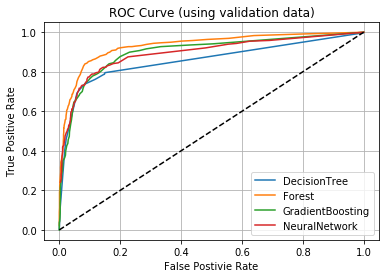

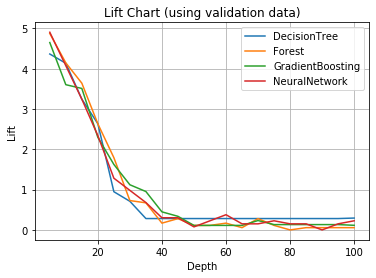

In [34]:
#/* Draw ROC charts */ 
plt.figure()
for key, grp in all_rocinfo.groupby(["model"]):
    plt.plot(grp["FPR"], grp["Sensitivity"], label=key)
plt.plot([0,1], [0,1], "k--")
plt.xlabel("False Postivie Rate")
plt.ylabel("True Positive Rate")
plt.grid(True)
plt.legend(loc="best")
plt.title("ROC Curve (using validation data)")
plt.show()

#/* Draw lift charts */
plt.figure()
for key, grp in all_liftinfo.groupby(["model"]):
    plt.plot(grp["Depth"], grp["Lift"], label=key)
plt.xlabel("Depth")
plt.ylabel("Lift")
plt.grid(True)
plt.legend(loc="best")
plt.title("Lift Chart (using validation data)")
plt.show();

## End CAS session

This closes the CAS session freeing resources for others to leverage

In [35]:
sess.close()